##Fit a prf model with frequency selectivity and an output nonlinearity.
July.2015 high-resolution CMRR data for the "match_nonmatch" project.

Project notes: https://drive.google.com/open?id=1m1rmotkmtgwY99Q_k71YDorUPq_DkCSJ0LselY13_v4

In [240]:
%pylab inline
import hrf_fitting.src.preprocessing as preproc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import nibabel as nib
import pickle
import matplotlib.animation as animation

from PIL import Image
from hrf_fitting.src.features import construct_placement_grid,make_kernel_grid,complex_ripple_filter,compute_grid_corners
from scipy.signal import convolve2d
from os import path
from sklearn import linear_model
from glob import glob
from sklearn.metrics import explained_variance_score,r2_score
from scipy.stats.mstats import zscore
from joblib import Parallel, delayed
from time import time
from scipy.interpolate import griddata

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


###Select data

select a subject and corresponding database

In [5]:
subject = 's1055'
db =  '/media/tnaselar/Data/July_2015_preproc/'+subject+'/PS/aligned_db.csv'

import into pandas dataframe and view it

In [6]:
data_db = pd.io.parsers.read_csv(db,header=0)
data_db.head(5)

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
0,0,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
1,1,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
2,2,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
3,3,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
4,4,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0


###Specify runs for training and testing the model

In [7]:
def select_run(row,runType):
    return row['runType'] in [runType]


wedge_runs = list(data_db[data_db.apply(select_run,axis=1,args=('wedge',))].runID)
bar_runs = list(data_db[data_db.apply(select_run,axis=1,args=('bar',))].runID)
art_runs = list(data_db[data_db.apply(select_run,axis=1,args=('art',))].runID)

training_runs = wedge_runs[1:3]+bar_runs[1:3]
selection_runs = wedge_runs[0:1]+bar_runs[0:1]
validation_runs = wedge_runs[5:-1]+bar_runs[5:-1]
# validation_run_ids = data_db[data_db.apply(lambda row: row['runType'] in validation_run_types,axis=1)].runID

In [8]:
data_db.iloc[training_runs] 

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
1,1,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
13,13,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
3,3,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
4,4,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0


In [9]:
data_db.iloc[selection_runs]

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
0,0,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
2,2,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0


In [10]:
data_db.iloc[validation_runs]

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
21,21,04/08/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
22,22,04/08/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0


###Load neural data

In [11]:
training_vols = preproc.load_runs(data_db,training_runs)
selection_vols = preproc.load_runs(data_db,selection_runs)
validation_vols = preproc.load_runs(data_db,validation_runs)

detrending run 0 with window_length: 101
detrending run 1 with window_length: 101
detrending run 2 with window_length: 101
detrending run 3 with window_length: 101
zscoring 0 thru 200
zscoring 200 thru 400
zscoring 400 thru 600
zscoring 600 thru 800
detrending run 0 with window_length: 101
detrending run 1 with window_length: 101
zscoring 0 thru 200
zscoring 200 thru 400
detrending run 0 with window_length: 101
detrending run 1 with window_length: 101
zscoring 0 thru 200
zscoring 200 thru 400


In [12]:
validation_vols

Reshape, mask, and remove inf's. Need to add this functionality to "load_runs"

In [13]:
##optional coronal slice selection
first_slice,last_slice = -25,-1

##first the mask. mucked up the database somehow, so reading in the brain mask is a stupid mess
bm = glob('/media'+data_db.iloc[training_runs[0]]['brain_mask'].split('/media')[2]+'/*.gz')
mask_image = nib.load(bm[0]).get_data().astype('bool') ##a numpy boolean

##now some indices for coronal slicing.
zdx = np.zeros(training_vols.shape[0:3]).astype('bool')
zdx[:,:,first_slice:last_slice] = True

##can't use any of the voxels with knackered values
finite_voxels = np.isfinite(training_vols.get_data()).all(axis=3)*np.isfinite(selection_vols.get_data()).all(axis=3)

mask_image = mask_image*zdx*finite_voxels

In [14]:
def apply_mask(vol,raveled_mask):
    vol = vol.get_data().reshape((np.prod(vol.shape[0:3]),vol.shape[3])).T  ##converts to (time, xyz)
    return vol[:,raveled_mask]
    

In [15]:
##test masking
mean_vol = preproc.load_runs(data_db,selection_runs,detrend=False,z_score=False)
mean_vol = apply_mask(mean_vol,mask_image.ravel()).mean(axis=0)
test_view = np.zeros(mask_image.shape).ravel()
test_view[mask_image.ravel()] = mean_vol
test_view = test_view.reshape(mask_image.shape)

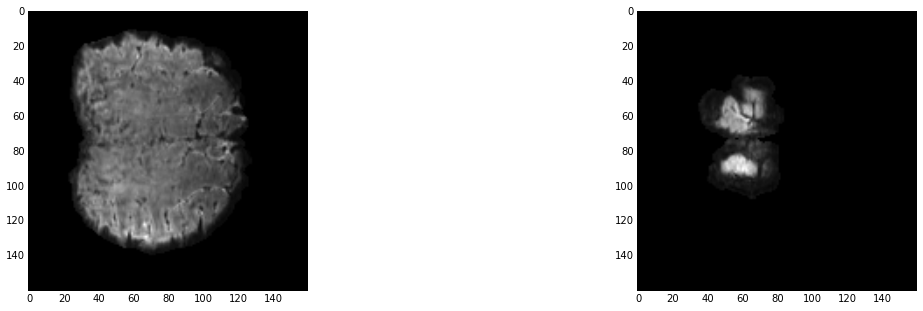

In [16]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(test_view[:,:,first_slice],cmap=cm.gray)
plt.subplot(1,2,2)
plt.imshow(test_view[:,:,last_slice-1],cmap=cm.gray)

In [17]:
training_vols = apply_mask(training_vols,mask_image.ravel()) 

In [18]:
print 'training vol dimensions: %s' %(training_vols.shape,)

training vol dimensions: (800, 165406)


In [19]:
selection_vols = apply_mask(selection_vols,mask_image.ravel()) 

In [20]:
print 'selection vol dimensions: %s' %(selection_vols.shape,)

selection vol dimensions: (400, 165406)


In [21]:
validation_vols = apply_mask(validation_vols,mask_image.ravel())

In [22]:
print 'validation vol dimensions: %s' %(validation_vols.shape,)

validation vol dimensions: (400, 165406)


###Load images
We happen to know that for the 'wedge' and 'bar' runs, the framefiles are identical. So we don't need
to all of them into memory. Instead, we load in one copy, and create a function that will be used to concatenate feature matrices when it's time to train the model.

In [23]:
##some important units
native_stim_size = 768. ##I just know this
working_image_size = 312.
image_downsampling = working_image_size/native_stim_size ##I choose this
pixel_per_deg = 34.751*image_downsampling    ##I just know this  
pixels_per_stimulus = int(native_stim_size*image_downsampling) 
wedge_nvols = data_db.iloc[selection_runs[0]].nvols ##we happen to know what 0 and 1 mean
bar_nvols = data_db.iloc[selection_runs[1]].nvols

print 'pixels per degree: %0.2f' %(pixel_per_deg)
print 'pixels per image: %d' %(pixels_per_stimulus)

pixels per degree: 14.12
pixels per image: 312


In [24]:
##list of stimulus frames, as they were presented
wedge_stim_list = preproc.load_frame_file(data_db.iloc[selection_runs[0]]) 
bar_stim_list = preproc.load_frame_file(data_db.iloc[selection_runs[1]])
pic_path = data_db.iloc[selection_runs[0]].picPath

In [25]:
wedge_imgs = np.array(map(lambda img: np.array(Image.open(img).convert('L').resize((pixels_per_stimulus,)*2)),
                          map(lambda f: path.join(pic_path,f),wedge_stim_list)),
                      ndmin=3)
print 'wedge images taking up %0.3f GB of RAM' %(wedge_imgs.nbytes/1024./1024./1024.)

wedge images taking up 0.408 GB of RAM


In [26]:
bar_imgs = np.array(map(lambda img: np.array(Image.open(img).convert('L').resize((pixels_per_stimulus,)*2)),
                          map(lambda f: path.join(pic_path,f),bar_stim_list)),
                    ndmin=3)
print 'bar images taking up %0.3f GB of RAM' %(bar_imgs.nbytes/1024./1024./1024.)

bar images taking up 0.408 GB of RAM


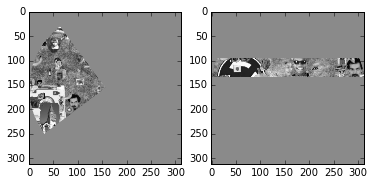

In [27]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(wedge_imgs[400,:,:],cmap=cm.gray)
plt.subplot(1,2,2)
plt.imshow(bar_imgs[400,:,:],cmap=cm.gray)

###Construct features

Specify the set of ripple filters

In [28]:

##preferences
min_cyc_deg = 0.1
max_cyc_deg = 3.
min_kernel_size = .5    ##deg
max_kernel_size = 10.5    ##deg
kernel_spacing = 2. ##deg
num_freq_levels = 2
num_size_levels = 2
boundary_condition = 1

##---frequencies
##cyc/deg
freq_df = pd.DataFrame(np.logspace(np.log10(min_cyc_deg),np.log10(max_cyc_deg),num=num_freq_levels,endpoint=True),
                       columns=['cyc/deg'])
##cyc/pix
freq_df['cyc/pix'] = freq_df['cyc/deg'].apply(lambda x: x/pixel_per_deg)
##cyc/image
freq_df['cyc/image'] = freq_df['cyc/pix'].apply(lambda x: x*pixels_per_stimulus)
##pix/cyc -- check to make sure greater than 6, as per Curtis Baker
freq_df['pix/cyc'] = freq_df['cyc/pix'].apply(lambda x: 1/x)

##---kernel sizes
##deg
size_df = pd.DataFrame(np.linspace(min_kernel_size, max_kernel_size,num=num_size_levels,endpoint=True),
                       columns = ['deg.'])
##pix
size_df['pix'] = size_df['deg.'].apply(lambda x: x*pixel_per_deg)



##---kernel position grid
pix_spacing = kernel_spacing*pixel_per_deg
corners=compute_grid_corners(working_image_size,size_df['pix'].min(),boundary_condition=1)  #not quite on edge of image
pos_x,pos_y=construct_placement_grid(corners,pix_spacing)
pos_x = pos_x.ravel()
pos_y = pos_y.ravel()

##---summarize
num_models = len(pos_x)*num_freq_levels*num_size_levels
print 'total number of models to evaluate (per voxel): %d' %(num_models)



total number of models to evaluate (per voxel): 400


Spatial frequencies in various units

In [29]:
freq_df

,cyc/deg,cyc/pix,cyc/image,pix/cyc
0,0.1,0.007083,2.210008,141.175937
1,3.0,0.212501,66.300250,4.705865


Kernel sizes in various units

In [30]:
size_df

,deg.,pix
0,0.5,7.058797
1,10.5,148.234734


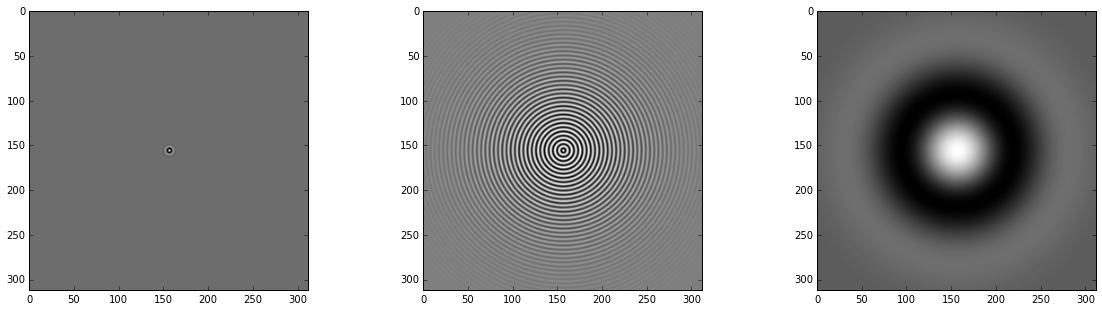

In [31]:
plt.figure(figsize=(20,5))

smallest_fastest = complex_ripple_filter(freq_df['cyc/image'].max(),(0,0),size_df['pix'].min(),pixels_per_stimulus)
plt.subplot(1,3,1)
plt.imshow(np.real(smallest_fastest),cmap=cm.gray)

biggest_fastest = complex_ripple_filter(freq_df['cyc/image'].max(),(0,0),size_df['pix'].max(),pixels_per_stimulus)
plt.subplot(1,3,2)
plt.imshow(np.real(biggest_fastest),cmap=cm.gray)


biggest_slowest = complex_ripple_filter(freq_df['cyc/image'].min(),(0,0),size_df['pix'].max(),pixels_per_stimulus)
plt.subplot(1,3,3)
plt.imshow(np.real(biggest_slowest),cmap=cm.gray)



###Fit the ripple model
Loop over all prf sizes, frequencies, and positions. At each iteration fit an independent model for each voxel. Evaluate the score against a held-out selection set. Keep track of the best model for each voxel.

In [32]:
##some parameters of the model
hrf_length = 15 ##20 s should do it.
alpha = 1 ## I dunno. For rige regression

A special function we need for creating feature matrices w/o filling up memory.

In [33]:
def concat_wedge_bar_matrices(wedge_feature_matrix=None,bar_feature_matrix=None,run_ids=None):
    total_rows = data_db['nvols'].iloc[run_ids].sum(axis=0)
    total_cols = wedge_feature_matrix.shape[1]
    nVols = wedge_feature_matrix.shape[0]
    final_feature_matrix = np.zeros((total_rows,total_cols))
    count = 0
    for row in data_db.iloc[run_ids].iterrows():  ##apparently this gives you a tuple with the index first
        run_type = row[1].runType
        if run_type == 'bar':
            final_feature_matrix[count:count+nVols,:] = bar_feature_matrix
        elif run_type == 'wedge':
            final_feature_matrix[count:count+nVols,:] = wedge_feature_matrix
        else:
            raise Exception('run type should only be bar or wedge. something is wrong.')
        count += nVols
    return final_feature_matrix

A reasonbly efficient scoring function. Sklearn doesn't deal with scoring many models at once

In [34]:
def corr2_coeff(A,B):
    N = A.shape[0]
    # Colwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(0)[None,:]
    B_mB = B - B.mean(0)[None,:]

    # Sum of squares across cols
    ssA = (A_mA**2).sum(0) 
    ssB = (B_mB**2).sum(0) 
    ss = np.sqrt(ssA)*np.sqrt(ssB)
    # Finally get corr coeff
    return np.sum(A_mA*B_mB,axis=0)/ss
#     return np.dot(A_mA,B_mB.T)/np.sqrt(np.dot(ssA[:,None],ssB[None]))

The main fitting / selection loop

In [35]:
##here are the guts of the fitting procedure, functionalized for each p'llization.
def main_proc(filters, p):        
#     print '===position: %d of %d' %(p, num_filters)
    wedge_features = np.abs(np.tensordot(wedge_imgs, filters[p,:,:],axes=2))
    bar_features = np.abs(np.tensordot(bar_imgs, filters[p,:,:],axes=2))
    downsampled_wedge_timeseries = preproc.nearest_neighbor_downsampling(wedge_features,wedge_nvols)
    downsampled_bar_timeseries = preproc.nearest_neighbor_downsampling(bar_features,bar_nvols)

    wedge_feature_matrix = preproc.construct_feature_matrix(np.atleast_2d(downsampled_wedge_timeseries).T,
                                                            hrf_length=hrf_length)
    bar_feature_matrix = preproc.construct_feature_matrix(np.atleast_2d(downsampled_bar_timeseries).T,
                                                            hrf_length=hrf_length)
    training_matrix = concat_wedge_bar_matrices(wedge_feature_matrix=wedge_feature_matrix,
                                                     bar_feature_matrix=bar_feature_matrix,
                                                     run_ids = training_runs)
#     print '=fitting model...'
    lin_mod = linear_model.Ridge(alpha=alpha,normalize=True).fit(training_matrix,training_vols)
#     print '=scoring model...'
    selection_matrix = concat_wedge_bar_matrices(wedge_feature_matrix=wedge_feature_matrix,
                                                     bar_feature_matrix=bar_feature_matrix,
                                                     run_ids = selection_runs)

    yhat = lin_mod.predict(selection_matrix)
    scr = corr2_coeff(selection_vols,yhat)
    return {p:(scr,lin_mod)}

In [36]:
##some functions for converting to polar coors on the fly. Should probably put these elsewhere
def ecc_func(x,y):
    return np.sqrt(x**2+y**2)

def ang_func(x,y):
    return np.angle(x+1j*y)


In [37]:
##convert list of dicts with keys into one flat dictionary
def flatten_list_of_dicts(list_of_dicts):
    flat_dict = {}
    for d in list_of_dicts:
        flat_dict.update(d)
    return flat_dict

In [38]:
##some containers for the results
model_idx = 0
num_voxels = training_vols.shape[1]
best_scr = -np.ones(num_voxels)
best_coefs = np.zeros((num_voxels,hrf_length))
best_intercept = np.zeros(num_voxels)
best_model_dx = np.zeros(num_voxels)
model_specs = []

In [39]:
##loop over size / freq / position, updating the "best" model for each voxel on each iteration.
for kernel_size in size_df['pix']:
    for freq in freq_df['cyc/image']:
        ##print 'constructing filters...'
        print '=====size/freq pair %d' %(model_idx)
        
        filters = make_kernel_grid(freq,kernel_size,pixels_per_stimulus,(pos_x,pos_y))

        num_filters = len(pos_x.ravel())
        
        ##utilize multi-processing. 
        start = time()
        ##model_info is list of dicts, key = model index, value = (scores,lin_mod) for all voxels 
        model_info = Parallel(n_jobs=3)(delayed(main_proc)(filters,p) for p in range(num_filters))
        print 'took %f minutes to pre-process images' %((time()-start)/60.)
        ##convert to one dictionary, with keys indicating model
        model_info = flatten_list_of_dicts(model_info)
        for p in range(len(model_info.keys())):
            model_specs.append({'size':kernel_size,
                                'freq':freq,
                                'pos_x': pos_x[p], 'pos_y': pos_y[p],
                                'ang': ang_func(pos_x[p],pos_y[p]),
                                'ecc': ecc_func(pos_x[p],pos_y[p])})
            mask_dx = np.where(model_info[p][0] > best_scr)[0] ##mask index of voxels who like current model.
            best_scr[mask_dx] = model_info[p][0][mask_dx] ##record the selection scores of these voxels
            best_coefs[mask_dx,:] = model_info[p][1].coef_[mask_dx,:] ##record the model weights
            best_intercept[mask_dx] = model_info[p][1].intercept_[mask_dx] ##...model intercept
            best_model_dx[mask_dx] = model_idx ##assign unique index to this model.
            model_idx += 1
        model_info = []

=====size/freq pair 0
constructing 100 filters
took 6.175360 minutes to pre-process images
=====size/freq pair 100
constructing 100 filters
took 5.354495 minutes to pre-process images
=====size/freq pair 200
constructing 100 filters
took 4.988300 minutes to pre-process images
=====size/freq pair 300
constructing 100 filters
took 4.959111 minutes to pre-process images


Now we unpack the results into an organized database that (should) make future analyses easier

In [137]:
#a container for the results. 
class population_model(object):
    '''
    population_model(brain_mask,size_of_stim,pix_per_deg,model_df,hrf_length,alpha,model_weights,model_b0)
    '''
    def __init__(self,brain_mask,size_of_stim,pix_per_deg, model_df,hrf_length,alpha,model_weights,model_b0):
        self.vol_dims = brain_mask.shape
        self.brain_mask = brain_mask
        self.size_of_stim = size_of_stim
        self.pix_per_deg = pix_per_deg
        self.model_df = model_df
        self.hrf_length = hrf_length
        self.alpha = alpha
        self.val_db = data_db.iloc[validation_runs]
        self.sel_db = data_db.iloc[selection_runs]
        self.trn_db = data_db.iloc[training_runs]
        self.model_weights = model_weights
        self.model_b0 = model_b0
    
    def get_model_intercepts(self,dx):
        return self.model_b0[dx]
    
    def get_model_weights(self,dx):
        wts = self.model_weights[dx,:]
        return wts
    
    def make_lin_mod(self,dx):
        wts = self.get_model_weights(dx)
        b0 = self.get_model_intercepts(dx)
        lin_mod = linear_model.Ridge(alpha=self.alpha,normalize=True)
        lin_mod.coef_ = wts
        lin_mod.intercept_ = b0
        return lin_mod
        
    def how_big_am_i(self):
        this_big = self.model_df.values.nbytes + self.model_weights.nbytes + self.model_b0.nbytes 
        this_big = this_big/1024./1024./1024.
        print 'I am %f GB' %(this_big)
        return this_big
    


In [138]:
##construct and populate database with voxel indices and model parameters for selected models
# 
prf_size = map(lambda vx: model_specs[vx]['size'], best_model_dx.astype('int64'))
prf_freq = map(lambda vx: model_specs[vx]['freq'], best_model_dx.astype('int64'))
prf_pos_x = map(lambda vx: model_specs[vx]['pos_x'], best_model_dx.astype('int64'))
prf_pos_y = map(lambda vx: model_specs[vx]['pos_y'], best_model_dx.astype('int64'))
prf_ang = map(lambda vx: model_specs[vx]['ang'], best_model_dx.astype('int64'))
prf_ecc = map(lambda vx: model_specs[vx]['ecc'], best_model_dx.astype('int64'))
idx_in_mask = range(len(best_scr))

best_prf = pd.DataFrame({'idx_in_mask':idx_in_mask,
                         'size':prf_size,
                         'freq':prf_freq,
                         'pos_x':prf_pos_x,
                         'pos_y':prf_pos_y,
                         'ang':prf_ang,
                         'ecc':prf_ecc,
                         'selection_score':best_scr}
                         )
                        

        
pop_mod = population_model(mask_image,
                           pixels_per_stimulus,
                           pixel_per_deg,
                           best_prf,
                           hrf_length,
                           alpha,
                           best_coefs,
                           best_intercept)
        

In [89]:
pop_mod.model_df.head()

,ang,ecc,freq,idx_in_mask,pos_x,pos_y,selection_score,size
0,-0.785398,70.211556,66.30025,0,49.647068,-49.647068,0.111813,148.234734
1,2.601173,96.496555,66.30025,1,-82.745113,49.647068,0.111528,148.234734
2,-1.249046,156.997813,66.30025,2,49.647068,-148.941203,0.126382,148.234734
3,2.736701,126.033601,66.30025,3,-115.843158,49.647068,0.149971,148.234734
4,-0.909753,188.687888,66.30025,4,115.843158,-148.941203,0.124682,148.234734


A histogram of scores on the selection set. Note there is some overfitting here, because we purposefully selected 
the best of many possible models for each voxel. Don't expect the histogram on the validation data to look quite this good.

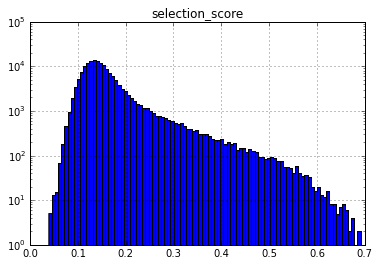

In [98]:
plt.figure
pop_mod.model_df.hist(column='selection_score',bins=100,log=True);

If we look at the temporal kernels for the best voxels (as evaluated on the selection set) we get some encouraging-looking results.

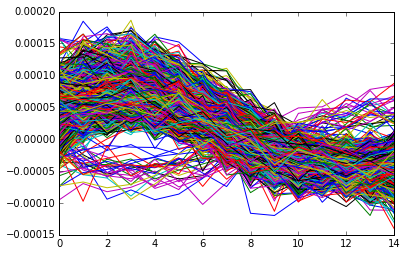

In [139]:
mxi = np.where(pop_mod.model_df['selection_score'] > 0.4)[0]
wts = pop_mod.get_model_weights(mxi)
plt.figure
_ = plt.plot(wts.T)


In [115]:
np.sum(pop_mod.model_df['selection_score'] > 0.4)

3072

Generate validation prediction scores

In [154]:
##vox will just be a bunch of voxels
def val_proc(vox):        
#   ##assume we've already grouped by model attributes. use min to uniquify.
    
    freq = pop_mod.model_df.loc[vox,'freq'].min() 
    pos_x,pos_y = pop_mod.model_df.loc[vox,'pos_x'].min(), pop_mod.model_df.loc[vox,'pos_y'].min()
    prf_size = pop_mod.model_df.loc[vox,'size'].min()
    
    start = time()
    filters = complex_ripple_filter(freq,
                                    (pos_x,pos_y),
                                    prf_size,
                                    pop_mod.size_of_stim)
    wedge_features = np.abs(np.tensordot(wedge_imgs, filters,axes=2))
    bar_features = np.abs(np.tensordot(bar_imgs, filters,axes=2))
    downsampled_wedge_timeseries = preproc.nearest_neighbor_downsampling(wedge_features,wedge_nvols)
    downsampled_bar_timeseries = preproc.nearest_neighbor_downsampling(bar_features,bar_nvols)

    wedge_feature_matrix = preproc.construct_feature_matrix(np.atleast_2d(downsampled_wedge_timeseries).T,
                                                            hrf_length=hrf_length)
    bar_feature_matrix = preproc.construct_feature_matrix(np.atleast_2d(downsampled_bar_timeseries).T,
                                                            hrf_length=hrf_length)
    validation_matrix = concat_wedge_bar_matrices(wedge_feature_matrix=wedge_feature_matrix,
                                                     bar_feature_matrix=bar_feature_matrix,
                                                     run_ids = validation_runs)
    yhat = pop_mod.make_lin_mod(vox).predict(validation_matrix)
    scrs = corr2_coeff(validation_vols[:,vox],yhat)
    print '====took %0.2f sec. to validate %d voxels' %((time()-start)/60., len(vox))
    return vox,scrs,yhat

In [ ]:
model_group = pop_mod.model_df.groupby(by=['size','freq','pos_x','pos_y'])

In [157]:
val_scores = Parallel(n_jobs=3,verbose=True)(delayed(val_proc)(grp.idx_in_mask.values) for name,grp in model_group)

[Parallel(n_jobs=3)]: Done   1 out of 376 | elapsed:    5.8s remaining: 36.2min
[Parallel(n_jobs=3)]: Done 376 out of 376 | elapsed: 12.0min finished


====took 0.10 sec. to validate 41 voxels
====took 0.10 sec. to validate 250 voxels
====took 0.12 sec. to validate 83 voxels
====took 0.10 sec. to validate 469 voxels====took 0.10 sec. to validate 105 voxels====took 0.08 sec. to validate 45 voxels


====took 0.10 sec. to validate 29 voxels====took 0.10 sec. to validate 226 voxels====took 0.11 sec. to validate 375 voxels


====took 0.09 sec. to validate 393 voxels====took 0.12 sec. to validate 320 voxels====took 0.12 sec. to validate 194 voxels


====took 0.08 sec. to validate 353 voxels====took 0.12 sec. to validate 25 voxels====took 0.12 sec. to validate 45 voxels


====took 0.09 sec. to validate 228 voxels====took 0.10 sec. to validate 303 voxels====took 0.11 sec. to validate 215 voxels


====took 0.09 sec. to validate 298 voxels====took 0.11 sec. to validate 213 voxels====took 0.10 sec. to validate 295 voxels


====took 0.12 sec. to validate 245 voxels====took 0.10 sec. to validate 229 voxels====took 0.09 sec. to validate 60 voxels



In [165]:
yhats.shape

(400, 41)

In [167]:
##add val scores, predictions to the model df
n_vox = np.sum(pop_mod.brain_mask)
val_pred = np.zeros((n_vox,val_scores[0][2].shape[0]))
for val_data in val_scores:
    vox = val_data[0]
    scores = val_data[1]
    yhats = val_data[2]
    pop_mod.model_df.loc[vox,'val_score'] = scores
    val_pred[vox,:]=yhats.T
#     pop_mod.model_df.loc[vox,'val_pred'] = yhats
pop_mod.val_pred = val_pred

In [284]:
with open('/media/tnaselar/Data/scratch/pop_mod.pkl','w') as f:
    pickle.dump(pop_mod,file = f)

In [3]:
with open('/media/tnaselar/Data/scratch/pop_mod.pkl','rb') as f:
    pop_mod = pickle.load(f)

###Model validation: correlation coeffs

In [168]:
np.sum(pop_mod.model_df['val_score'] > 0.2)

11020

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02e229cd90>]], dtype=object)

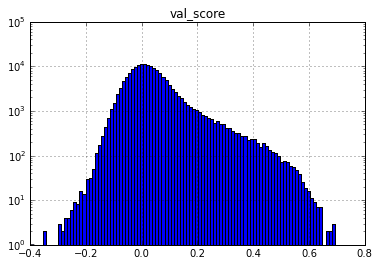

In [170]:
plt.figure
pop_mod.model_df.hist(column='val_score',bins=100,log=True)

###Model validation: brain visualization

We expect the map of scores (on the selection set) to look reasonable. It does. Check out the saved volumes in fslview.

In [172]:
mean_vol = preproc.load_runs(data_db,validation_runs,detrend=False,z_score=False)
mean_vol = apply_mask(mean_vol,mask_image.ravel()).mean(axis=0)

brain_view = np.zeros(mask_image.shape).ravel()
brain_view[mask_image.ravel()] = mean_vol
brain_view = brain_view.reshape(mask_image.shape)

In [179]:
score_view = np.zeros(pop_mod.brain_mask.shape).ravel()
mask_dx = np.where(pop_mod.brain_mask.ravel())[0]

In [178]:
mask_dx[0].shape

(165406,)

In [180]:
vx = pop_mod.model_df['idx_in_mask'].values 
vs = pop_mod.model_df['val_score'].values 
score_view[mask_dx[vx]]=vs
score_view = score_view.reshape(mask_image.shape)

In [181]:
nib.save(nib.Nifti1Image(brain_view,affine=np.eye(4)),'/media/tnaselar/Data/scratch/brain_view.nii')

nib.save(nib.Nifti1Image(score_view,affine=np.eye(4)),'/media/tnaselar/Data/scratch/score_view.nii')

###Model validation: temporal kernels

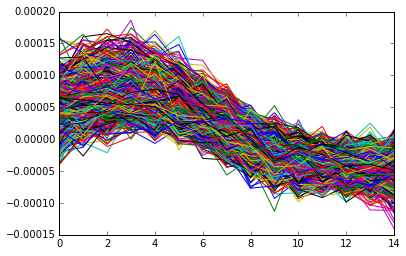

In [185]:
mxi = np.where(pop_mod.model_df['val_score'] > 0.4)[0]
wts = pop_mod.get_model_weights(mxi)
plt.figure
_ = plt.plot(wts.T)

###Model validation: ecc vs. size and freq

In [228]:
th = -0.2
ecc_group = pop_mod.model_df.groupby(['ecc'],as_index=False)

average size (deg): 7.603716


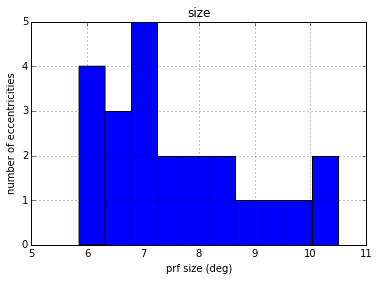

In [229]:
mean_size = ecc_group.agg(lambda x: x.loc[x['val_score']>th,'size'].mean()/pop_mod.pix_per_deg)[['ecc','size']]
mean_size.hist(column='size',bins=10)
plt.xlabel('prf size (deg)')
plt.ylabel('number of eccentricities')
print 'average size (deg): %f' %(mean_size['size'].mean())

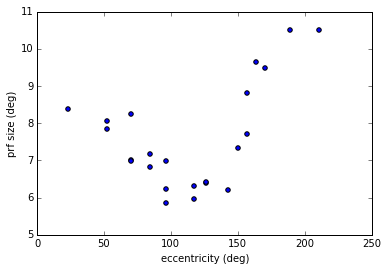

In [230]:
plt.scatter(mean_size['ecc'],mean_size['size'])
plt.xlabel('eccentricity (deg)')
plt.ylabel('prf size (deg)')

average freq (deg): 2.535645


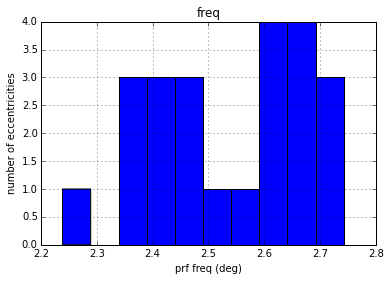

In [231]:
mean_freq = ecc_group.agg(lambda x: x.loc[x['val_score']>th,'freq'].mean()*(1./pop_mod.size_of_stim)*pop_mod.pix_per_deg)[['ecc','freq']]
mean_freq.hist(column='freq',bins=10)
plt.xlabel('prf freq (deg)')
plt.ylabel('number of eccentricities')
print 'average freq (deg): %f' %(mean_freq['freq'].mean())

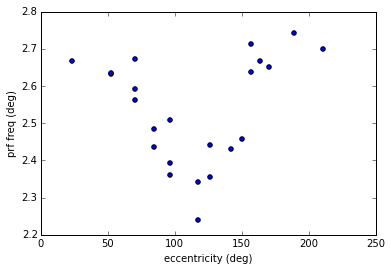

In [232]:
plt.scatter(mean_freq['ecc'],mean_freq['freq'])
plt.xlabel('eccentricity (deg)')
plt.ylabel('prf freq (deg)')

###Model validation: projective imaging

Construct movie

In [238]:
pos_group = pop_mod.model_df.groupby(by=['pos_x','pos_y'],as_index = False)
n_times = 400
grid_shape = (10*10,n_times)
p_image = np.zeros(grid_shape)
x_min = pop_mod.model_df['pos_x'].min()
x_max = pop_mod.model_df['pos_x'].max()
y_min = pop_mod.model_df['pos_y'].min()
y_max = pop_mod.model_df['pos_y'].max()
space_unit = 1 #pixel_per_deg ##one deg.
time_unit = 1 ##one TR

##create the space-time grid for interpolating
X,Y = np.meshgrid(np.arange(x_min,x_max,space_unit),np.arange(y_min,y_max,space_unit))


##for visualizing
movie = np.zeros((n_times,len(X),len(Y)))

cnt = 0
POS_X = []
POS_Y = []
for name,grp in pos_group:
    idx = grp.idx_in_mask.values
    POS_X.append(grp.pos_x.min())
    POS_Y.append(grp.pos_y.min())
    p_image[cnt,:] = pop_mod.val_pred[idx,:].mean(axis=0)
    cnt += 1
    
for movie_frame in range(n_times):
    movie[movie_frame,:,:] = griddata((POS_X,POS_Y),p_image[:,movie_frame],(X,Y))

Check one frame

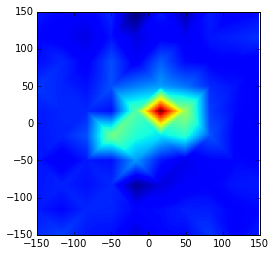

In [239]:
fig=plt.figure()
ax = fig.add_subplot(111)
plt.pcolor(X,Y,movie[175,:,:])
ax.set_aspect('equal')

Convert to avi and save

In [242]:
dpi = 100

##from somewhere on stackoverflow
def ani_frame(movie):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    im = ax.imshow(rand(18,18),cmap='jet',interpolation='nearest')
    im.set_clim([-.1,.1])
    fig.set_size_inches([5,5])


    tight_layout()


    def update_img(n):
        tmp = movie[n,:,:]
        im.set_data(tmp)
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,frames=400)
    writer = animation.writers['avconv'](fps=10)

    ani.save('/media/tnaselar/Data/demo.avi',writer=writer,dpi=dpi)
    return ani

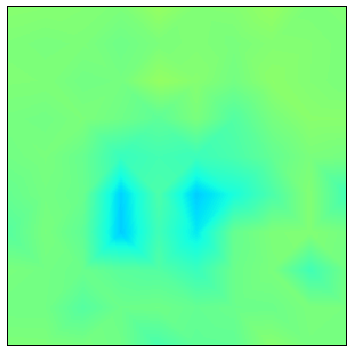

In [243]:
ani_frame(movie)